## Understanding the data

Let's first load the data and have a first glance on what we have

In [60]:
import json
import pandas as pd
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt
import numpy as np
from datasketch import MinHash, MinHashLSH
from hashlib import sha1

In [23]:
with open('../../dataset/scraped_raw/elinux_dataset.json', 'r') as elinux_file:
    elinux_data = json.load(elinux_file)

with open('../../dataset/scraped_raw/yocto_dataset.json', 'r') as yocto_file:
    yocto_data = json.load(yocto_file)

with open('../../dataset/scraped_raw/tdx_dataset.json', 'r') as tdx_file:
    tdx_data = json.load(tdx_file)

with open('../../dataset/scraped_raw/kernel_dataset.json', 'r') as kernel_file:
    kernel_data = json.load(kernel_file)

elinux_df = pd.DataFrame(elinux_data)
yocto_df = pd.DataFrame(yocto_data)
tdx_df = pd.DataFrame(tdx_data)
kernel_df = pd.DataFrame(kernel_data)

df = pd.concat([elinux_df, yocto_df, tdx_df, kernel_df], ignore_index=True)

In [24]:
num_urls = df['url'].nunique()
num_sources = df['categories'].apply(lambda x: len(x) if x else 0).sum()
avg_text_length = df['article_text'].apply(len).mean()

print(f"Number of URLs scraped: {num_urls}")
print(f"Number of unique sources: {num_sources}")
print(f"Average length of texts: {avg_text_length}")

Number of URLs scraped: 105478
Number of unique sources: 353494
Average length of texts: 11381.307773985589


Now we can go for something more "insightful". Inspired by the [FineWeb](https://huggingface.co/spaces/HuggingFaceFW/blogpost-fineweb-v1) dataset we can have the following:

1. Token Count: We use the GPT-2 tokenizer to calculate the number of tokens in each article.
2. Source Diversity: We count the unique categories to determine the diversity of the content sources.
3. Text Length Distribution: We calculate the length of each article's text and visualize its distribution.

In [25]:
domain_mapping = {
    'elinux_dataset.json': ['https://elinux.org'],
    'yocto_dataset.json': ['docs.yoctoproject.org', 'wiki.yoctoproject.org'],
    'tdx_dataset.json': ['https://developer.toradex.com'],
    'kernel_dataset.json': ['docs.kernel.org', 'docs.u-boot.org']
}

# Add a column for domains
def assign_domains(row):
    if 'elinux' in row['url']:
        return domain_mapping['elinux_dataset.json']
    elif 'yocto' in row['url']:
        return domain_mapping['yocto_dataset.json']
    elif 'toradex' in row['url']:
        return domain_mapping['tdx_dataset.json']
    elif 'kernel' in row['url'] or 'u-boot' in row['url']:
        return domain_mapping['kernel_dataset.json']

df['domains'] = df.apply(assign_domains, axis=1)

In [26]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Calculate number of tokens
df['token_count'] = df['article_text'].apply(lambda x: len(tokenizer.tokenize(x)))
avg_token_length = df['token_count'].mean()


# Calculate statistics
num_urls = df['url'].nunique()
num_domains = len(set(domain for domains in df['domains'] for domain in domains))
total_tokens = df['token_count'].sum()

# Print statistics
print(f"Number of unique URLs: {num_urls}")
print(f"Number of unique domains: {num_domains}")
print(f"Average token length: {avg_token_length:.2f} tokens")
print(f"Total number of tokens: {total_tokens}")

json = df.to_json('../../dataset/scraped_raw/dataset_raw.jsonl') # 1.2GB File

Number of unique URLs: 105478
Number of unique domains: 6
Average token length: 3581.74 tokens
Total number of tokens: 377801732


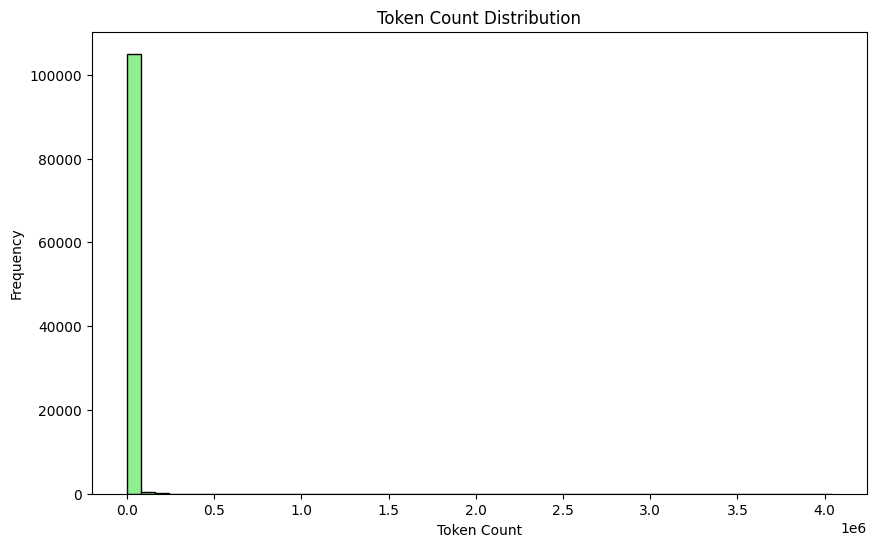

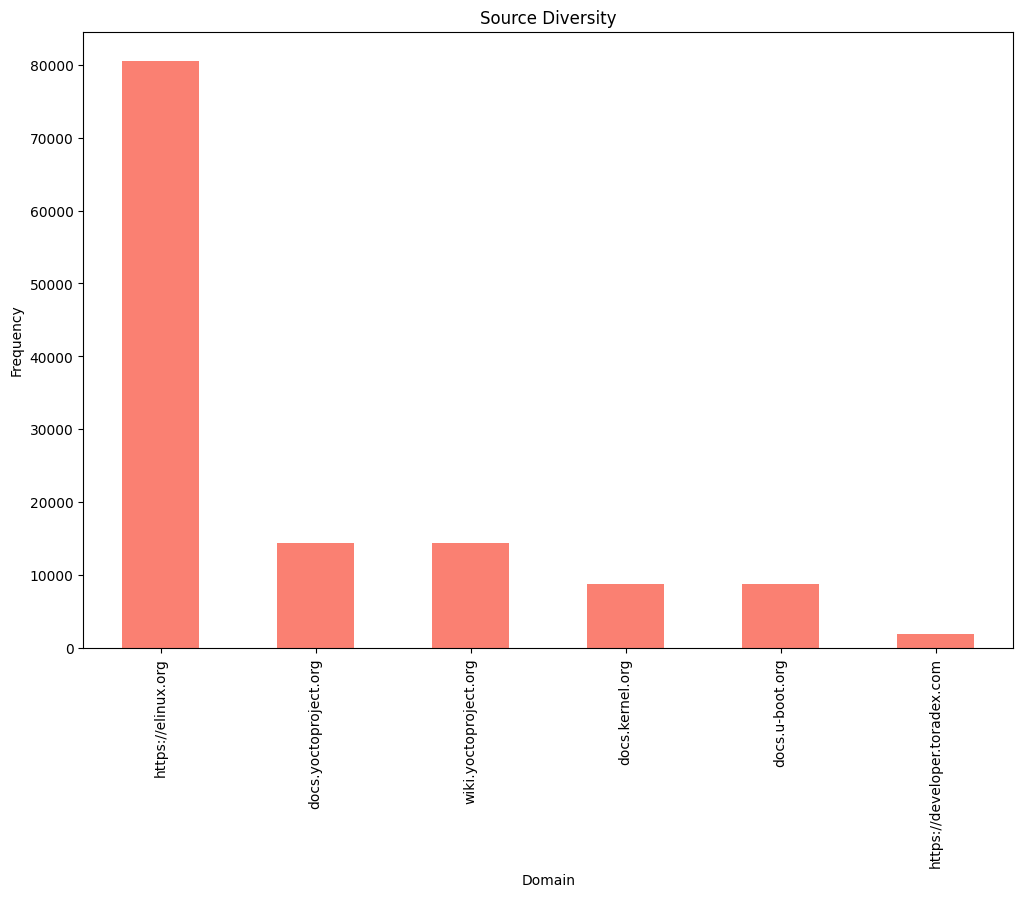

In [30]:
# Plot token count distribution
plt.figure(figsize=(10, 6))
plt.hist(df['token_count'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Token Count Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

# Plot source diversity
domain_counts = df['domains'].explode().value_counts()
plt.figure(figsize=(12, 8))
domain_counts.plot(kind='bar', color='salmon')
plt.title('Source Diversity')
plt.xlabel('Domain')
plt.ylabel('Frequency')
plt.show()

## Filter and Deduplicate Content

### First Filter: Removing waste content/link

In [41]:
# Step 1: Remove articles with titles indicating revisions
df_filtered = df[~df['title'].str.contains('Difference between revisions', case=False, na=False)]

# Step 2: Remove articles with the same URL and title
df_filtered = df_filtered.drop_duplicates(subset=['url', 'title'], keep='first')

In [42]:
# Calculate statistics after filtering
num_urls_filtered = df_filtered['url'].nunique()
avg_token_length_filtered = df_filtered['token_count'].mean()
total_tokens_filtered = df_filtered['token_count'].sum()

# Print statistics
print(f"""
Number of unique URLs: 
Initial: {num_urls} | After 1st filter: {num_urls_filtered}
""")

print(f"""
Average token length:
Initial: {avg_token_length:.2f} tokens | After 1st filter: {avg_token_length_filtered:.2f} tokens""")

print(f"""
Total number of tokens: 
Initial: {total_tokens} | After 1st filter: {total_tokens_filtered}""")



Number of unique URLs: 
Initial: 105478 | After 1st filter: 52596


Average token length:
Initial: 3581.74 tokens | After 1st filter: 5019.21 tokens

Total number of tokens: 
Initial: 377801732 | After 1st filter: 263990201


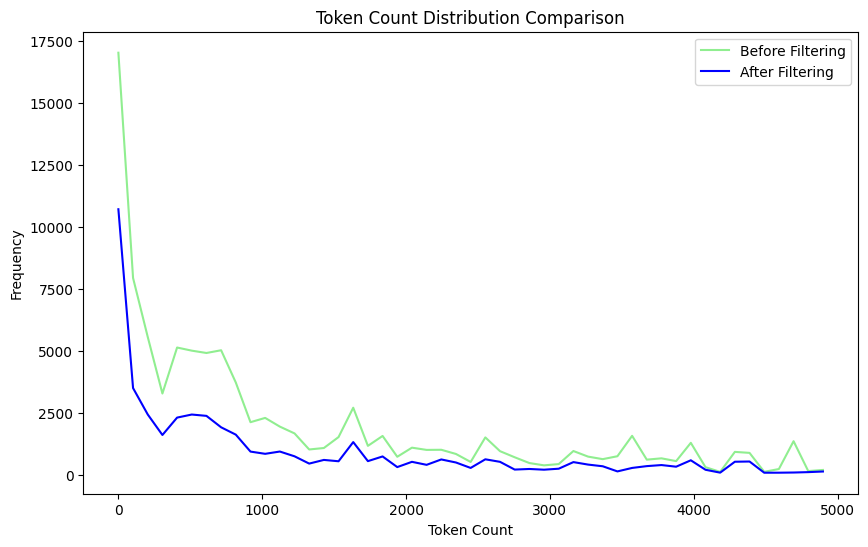

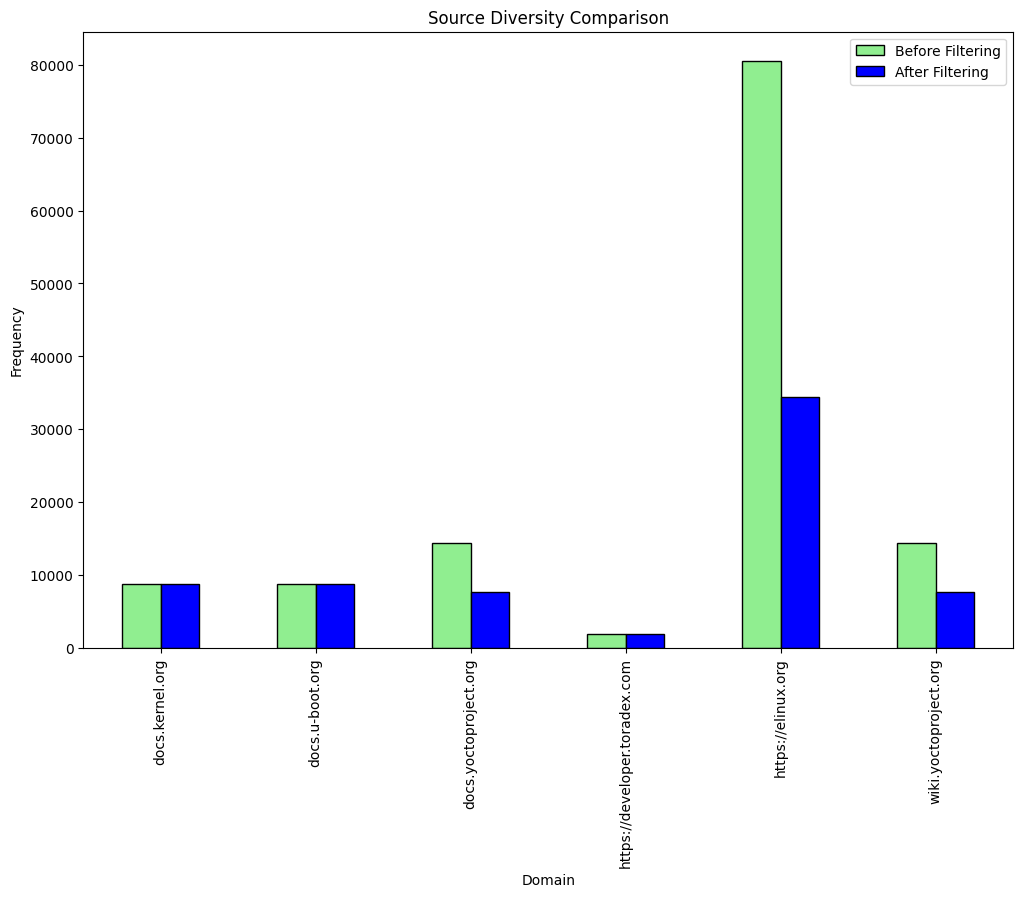

In [48]:
# Calculate histogram data
bins = np.linspace(0, 5000, 50)  # Adjust the range and number of bins as needed
hist_initial, _ = np.histogram(df['token_count'], bins=bins)
hist_filtered, _ = np.histogram(df_filtered['token_count'], bins=bins)

# Plot token count distribution comparison
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], hist_initial, color='lightgreen', label='Before Filtering')
plt.plot(bins[:-1], hist_filtered, color='blue', label='After Filtering')
plt.title('Token Count Distribution Comparison')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot source diversity comparison
domain_counts_initial = df['domains'].explode().value_counts()
domain_counts_filtered = df_filtered['domains'].explode().value_counts()

# Merge counts for comparison plot
domain_counts_comparison = pd.DataFrame({
    'Before Filtering': domain_counts_initial,
    'After Filtering': domain_counts_filtered
}).fillna(0)

domain_counts_comparison.plot(kind='bar', figsize=(12, 8), color=['lightgreen', 'blue'], edgecolor='black')
plt.title('Source Diversity Comparison')
plt.xlabel('Domain')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Second Filter: MinHash deduplication

The MinHash algorithm for deduplication of content is based on [MinHash Tutorial with Python Code](https://chrisjmccormick.wordpress.com/2015/06/12/minhash-tutorial-with-python-code/) and uses [datasketch](https://github.com/ekzhu/datasketch) 

#### Using Datasketch

In [50]:
# Function to create a MinHash object from text
def get_minhash(text, num_perm=128):
    minhash = MinHash(num_perm=num_perm)
    for word in text.split():
        minhash.update(word.encode('utf8'))
    return minhash

# Create MinHash LSH for deduplication
lsh = MinHashLSH(threshold=0.9, num_perm=128)

# Add documents to LSH and deduplicate
unique_docs = []
titles_seen = set()
for idx, row in df_filtered.iterrows():
    text = row['article_text']
    title = row['title']
    minhash = get_minhash(text)
    
    if title not in titles_seen and not lsh.query(minhash):
        lsh.insert(idx, minhash)
        unique_docs.append(row)
        titles_seen.add(title)

# Create a DataFrame from the unique documents
df_deduplicated = pd.DataFrame(unique_docs)

# Calculate statistics after MinHash deduplication
num_urls_deduplicated = df_deduplicated['url'].nunique()
avg_token_length_deduplicated = df_deduplicated['token_count'].mean()
total_tokens_deduplicated = df_deduplicated['token_count'].sum()

# Print statistics
print(f"""
Number of unique URLs: 
Initial: {num_urls} | After 1st filter: {num_urls_filtered} | After MinHash deduplication: {num_urls_deduplicated}
""")

print(f"""
Average token length:
Initial: {avg_token_length:.2f} tokens | After 1st filter: {avg_token_length_filtered:.2f} tokens | After MinHash deduplication: {avg_token_length_deduplicated:.2f} tokens
""")

print(f"""
Total number of tokens: 
Initial: {total_tokens} | After 1st filter: {total_tokens_filtered} | After MinHash deduplication: {total_tokens_deduplicated}
""")


Number of unique URLs: 
Initial: 105478 | After 1st filter: 52596 | After MinHash deduplication: 5509


Average token length:
Initial: 3581.74 tokens | After 1st filter: 5019.21 tokens | After MinHash deduplication: 24594.74 tokens


Total number of tokens: 
Initial: 377801732 | After 1st filter: 263990201 | After MinHash deduplication: 135492450



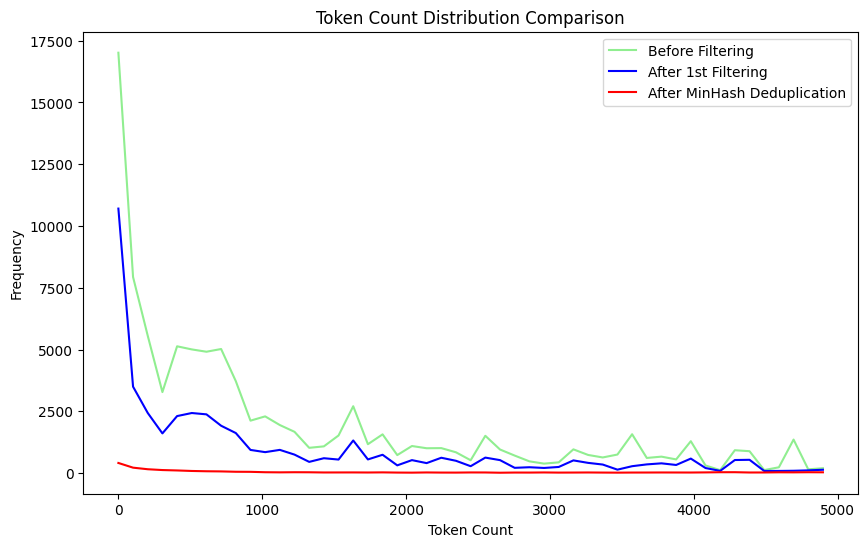

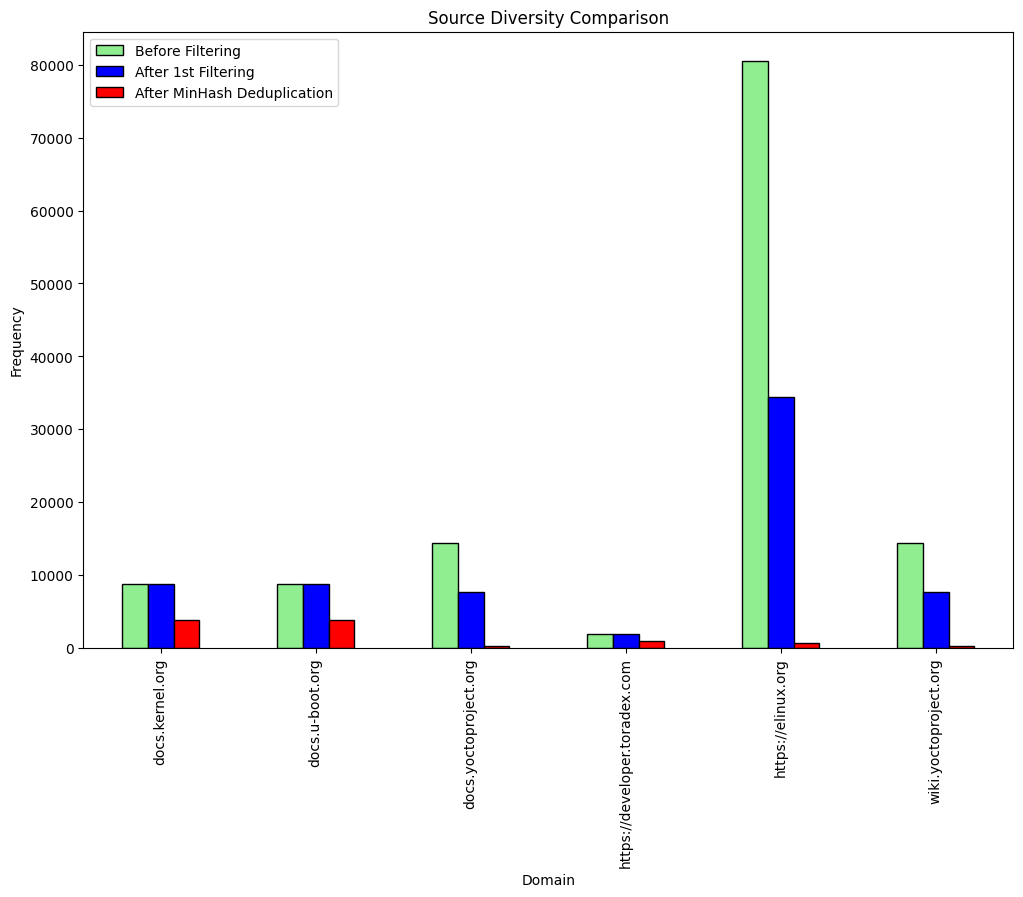

In [55]:
# Plot token count distribution comparison as histogram
# Calculate histogram data
bins = np.linspace(0, 5000, 50)  # Adjust the range and number of bins as needed
hist_initial, _ = np.histogram(df['token_count'], bins=bins)
hist_filtered, _ = np.histogram(df_filtered['token_count'], bins=bins)
hist_deduplicated, _ = np.histogram(df_deduplicated['token_count'], bins=bins)

# Plot token count distribution comparison
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], hist_initial, color='lightgreen', label='Before Filtering')
plt.plot(bins[:-1], hist_filtered, color='blue', label='After 1st Filtering')
plt.plot(bins[:-1], hist_deduplicated, color='red', label='After MinHash Deduplication')
plt.title('Token Count Distribution Comparison')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot source diversity comparison as bar chart
domain_counts_initial = df['domains'].explode().value_counts()
domain_counts_filtered = df_filtered['domains'].explode().value_counts()
domain_counts_deduplicated = df_deduplicated['domains'].explode().value_counts()

# Merge counts for comparison plot
domain_counts_comparison = pd.DataFrame({
    'Before Filtering': domain_counts_initial,
    'After 1st Filtering': domain_counts_filtered,
    'After MinHash Deduplication': domain_counts_deduplicated
}).fillna(0)

domain_counts_comparison.plot(kind='bar', figsize=(12, 8), color=['lightgreen', 'blue', 'red'], edgecolor='black')
plt.title('Source Diversity Comparison')
plt.xlabel('Domain')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Root way 

In [58]:
# Function to create a MinHash signature for a document
def minhash_signature(text, num_hashes=200):
    # Create a list of unique words
    words = set(text.split())

    # Initialize minhash signature as a list of max values
    signature = [float('inf')] * num_hashes

    for word in words:
        word_hash = int(sha1(word.encode('utf8')).hexdigest(), 16)
        for i in range(num_hashes):
            # Apply the i-th hash function
            a, b = np.random.randint(1, 10000, size=2)
            hash_value = (a * word_hash + b) % 2**32
            if hash_value < signature[i]:
                signature[i] = hash_value

    return signature

# Function to calculate Jaccard similarity between two signatures
def jaccard_similarity(sig1, sig2):
    assert len(sig1) == len(sig2)
    return np.mean(np.array(sig1) == np.array(sig2))

In [61]:
# Create MinHash signatures for all documents
df_filtered['minhash_signature'] = df_filtered['article_text'].apply(lambda text: minhash_signature(text))

# Deduplicate based on MinHash signatures
unique_docs = []
signatures_seen = []

for idx, row in df_filtered.iterrows():
    signature = row['minhash_signature']
    is_duplicate = False
    
    for seen_signature in signatures_seen:
        if jaccard_similarity(signature, seen_signature) > 0.9:
            is_duplicate = True
            break
    
    if not is_duplicate:
        unique_docs.append(row)
        signatures_seen.append(signature)

# Create a DataFrame from the unique documents
df_deduplicated = pd.DataFrame(unique_docs)

# Calculate statistics after MinHash deduplication
num_urls_deduplicated = df_deduplicated['url'].nunique()
avg_token_length_deduplicated = df_deduplicated['token_count'].mean()
total_tokens_deduplicated = df_deduplicated['token_count'].sum()

# Print statistics
print(f"""
Number of unique URLs: 
Initial: {num_urls} | After 1st filter: {num_urls_filtered} | After MinHash deduplication: {num_urls_deduplicated}
""")

print(f"""
Average token length:
Initial: {avg_token_length:.2f} tokens | After 1st filter: {avg_token_length_filtered:.2f} tokens | After MinHash deduplication: {avg_token_length_deduplicated:.2f} tokens
""")

print(f"""
Total number of tokens: 
Initial: {total_tokens} | After 1st filter: {total_tokens_filtered} | After MinHash deduplication: {total_tokens_deduplicated}
""")


In [ ]:

# Calculate histogram data for line plot
bins = np.linspace(0, 5000, 50)
hist_initial, _ = np.histogram(df['token_count'], bins=bins)
hist_filtered, _ = np.histogram(df_filtered['token_count'], bins=bins)
hist_deduplicated, _ = np.histogram(df_deduplicated['token_count'], bins=bins)

# Plot token count distribution comparison
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], hist_initial, color='lightgreen', label='Before Filtering')
plt.plot(bins[:-1], hist_filtered, color='blue', label='After 1st Filtering')
plt.plot(bins[:-1], hist_deduplicated, color='red', label='After MinHash Deduplication')
plt.title('Token Count Distribution Comparison')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot source diversity comparison
domain_counts_initial = df['domains'].explode().value_counts()
domain_counts_filtered = df_filtered['domains'].explode().value_counts()
domain_counts_deduplicated = df_deduplicated['domains'].explode().value_counts()

# Merge counts for comparison plot
domain_counts_comparison = pd.DataFrame({
    'Before Filtering': domain_counts_initial,
    'After 1st Filtering': domain_counts_filtered,
    'After MinHash Deduplication': domain_counts_deduplicated
}).fillna(0)

domain_counts_comparison.plot(kind='bar', figsize=(12, 8), color=['lightgreen', 'blue', 'red'], edgecolor='black')
plt.title('Source Diversity Comparison')
plt.xlabel('Domain')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
df_deduplicated.to_json('../../dataset/deduplicated_dataset.json', orient='records', lines=True)